# MNIST Tutorial for Beginners

### Loading Libraries and Setting Up

In [46]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from timeit import default_timer as timer
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' # For faster processing if you have a GPU

# Some Helper functions

In [47]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Loading in data and looking at it thoroughly.

In [48]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [49]:
# Basic information about the training and testing dataset
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
img_train, label_train = train_dataset[0]
img_test, label_test = test_dataset[0]
print(f'Shape of each image in the training dataset: {img_train.shape}')
print(f'Shape of each image in the testing dataset: {img_test.shape}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

Number of training samples: 60000
Number of test samples: 10000
Shape of each image in the training dataset: torch.Size([1, 28, 28])
Shape of each image in the testing dataset: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


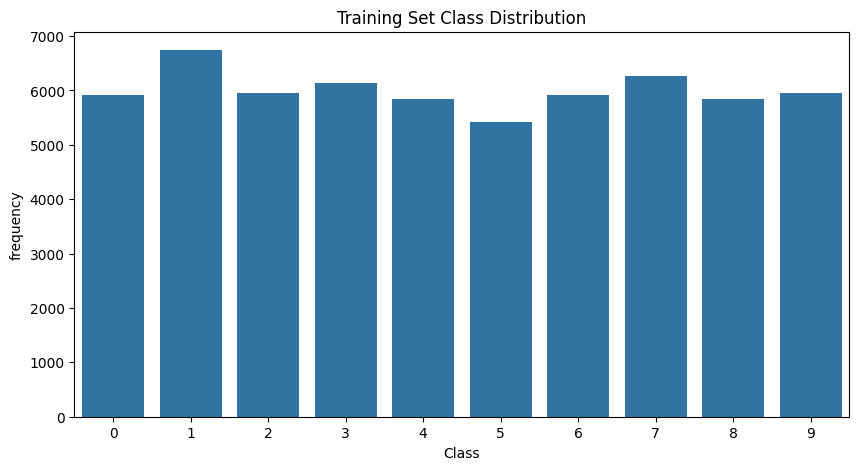

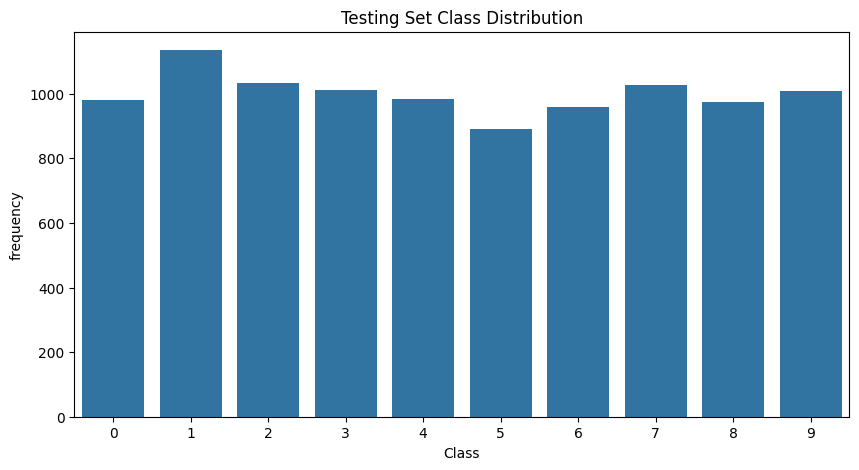

In [50]:
# Let's look at the class distribution. We want to identify whether the classes are balanced.
train_labels_df = pd.DataFrame(train_dataset.targets.numpy(), columns=['label'])
test_labels_df = pd.DataFrame(test_dataset.targets.numpy(), columns=['label'])

def plot_class_distribution(labels_df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=labels_df, x = 'label')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('frequency')
    plt.show()

plot_class_distribution(train_labels_df, 'Training Set Class Distribution')
plot_class_distribution(test_labels_df, 'Testing Set Class Distribution')


We see that the classes are slightly imbalanced. However, we can also observe that the imbalances are roughly similar in both datasets. This indicates (but we never know for certain), that the images are retrieved from the same distribution. 

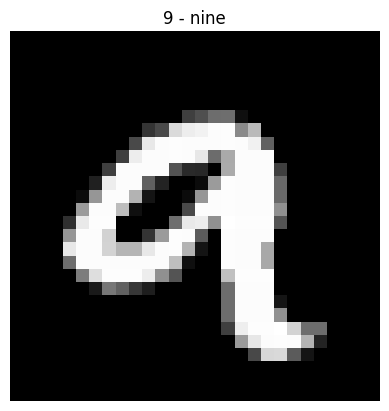

In [51]:
# We might want to set the seed to plot the same images
# torch.manual_seed(9)

class_names = train_dataset.classes

random_idx = torch.randint(low=0, high=len(train_dataset), size=[1]).item()
img, label = train_dataset[random_idx]
plt.imshow(img.squeeze(), cmap='gray') 
plt.title(class_names[label])
plt.axis('off')
plt.show()

From running the above code some times, we can see that most numbers look recognizable, but also that some are more difficult to guess than others. This is something we will have to take into account after our model has made predictions. It's always important to recognize that when our model makes mistakes, we *look* at these mistakes, because maybe we shouldn't call it a mistake:)

When we are working with images, we must not forget that each pixel is a feature. Therefore, as we would normally inspect our features (f.e. in tabular data) and their distribution, we can do the same for the pixels.

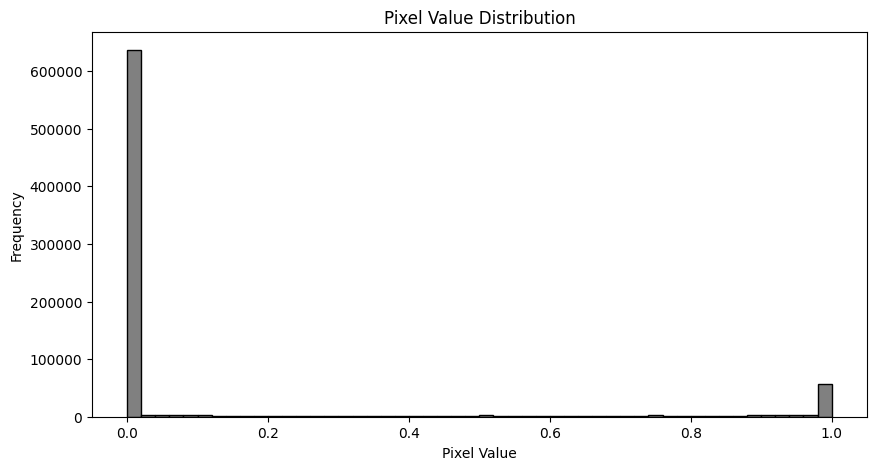

In [52]:
# Visualize the distribution of pixel values
def plot_pixel_distribution(dataset, num_samples=1000):
    pixels = np.concatenate([img.numpy().flatten() for img, _ in torch.utils.data.Subset(dataset, np.random.choice(len(dataset), num_samples, replace=False))])
    plt.figure(figsize=(10, 5))
    plt.hist(pixels, bins=50, color='gray', edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Value Distribution')
    plt.show()

plot_pixel_distribution(train_dataset)


Now that we understand roughly what are data looks like, we will use DataLoaders to efficiently load the data into batches, which is important for training neural networks. Moreover, we can decide whether we want to shuffle the data. We want to shuffle the data in the training dataloader to ensure diversity. There is also a lot of built-in support for data iteration, and just overall eases the job for us.

In [53]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Baseline linear model
We build a baseline linear model for comparing with later models.

In [54]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=28*28, out_features=10) # Lazy Linear initializes the input_dimension based on the input.

    def forward(self, X):
        return self.linear(X.reshape(-1, 28*28))

We define a training and evaluating loop. This should be generalizable for other models as well.

In [58]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.
        y_pred = model(X) # We make the predictions

        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [59]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.

            y_pred = model(X) # We make the predictions

            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_loss += loss
            test_acc += acc

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Train loss: {test_loss:.5f} | Train accuracy: {test_acc:.2f}%")

In [60]:
EPOCHS = 10

baseline_model = BaseLineModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(), lr=0.01)

for epoch in range(EPOCHS):
    train_step(baseline_model, train_loader, loss_fn, optimizer, device)
    test_step(baseline_model, test_loader, loss_fn, device)

shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape of y_pred: torch.Size([64, 10]) and shape of y: torch.Size([64])
shape 

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [ ]:
train_loader[0][0].shape

TypeError: 'DataLoader' object is not subscriptable